In [1]:
import torch
import torch.nn as nn
import pandas as pd
from chessEngine import ChessEncoder, MLPEngine
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import CosineAnnealingLR

# Preprocessing

In [2]:
df = pd.read_csv('fen_analysis.csv').sample(frac=1)[:30000] # This shuffles the rows
df

,fen_value,score
6704,rnbqkbnr/pp1ppppp/8/8/3pP3/5N2/PPP2PPP/RNBQKB1...,-29
107172,8/3r3k/p6p/8/4PK2/P1B2NP1/8/8 b - - 7 46,-331
170981,1R6/3r1k2/6p1/2B5/7P/2PP4/P2K4/8 b - - 2 43,-527
17066,r2qk2r/1pp2ppp/p1n1pn2/3p4/2PP4/1P2PP2/PB1Q1P1...,-54
267992,r1b2rk1/pp3ppp/3b1q2/2p5/3pP3/P2P1P2/1P2B1PP/R...,-159
...,...,...
238230,rnb1kbn1/pp3pp1/2p1p1q1/3p3r/2P2PpP/1Q2P3/PP1P...,-258
199217,8/pp2k3/2p4p/4P3/2r1P3/3K4/6PP/8 b - - 1 32,534
160261,r4rk1/p3b2p/b4qp1/2p5/8/4p3/PPPQ2PP/2KR4 w - -...,-705
16847,rn1qkb1r/1bp2p2/p3pn1p/3pN1p1/PpPP4/1P1BP2P/3N...,-117


In [3]:
encoder_object = ChessEncoder()

In [4]:
fen_encodings = []
for fen_i in df['fen_value']:
    encoded_fen = encoder_object.encode_fen(fen_i)
    fen_encodings.append(encoded_fen)

In [5]:
X = torch.tensor(fen_encodings, dtype=torch.int32)

In [6]:
score_encodings = []
for y_i in df['score']:
    # print(y_i)
    encoded_score = encoder_object.encode_score(str(y_i))
    score_encodings.append(encoded_score)
y = torch.tensor(score_encodings, dtype=torch.float32)

In [7]:
X.shape, y.shape

(torch.Size([30000, 70]), torch.Size([30000]))

# Helper Functions

In [8]:
val_split = 10000
test_split = 10000

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [10]:
def get_batch(X, Y, bs):
    
    assert isinstance(X, torch.Tensor)
    assert isinstance(Y, torch.Tensor)

    batch = torch.randint(0, len(X), (bs,))
    x = X[batch].to(device)
    y = Y[batch].to(device).to(torch.bfloat16)
    return x, y
# b = get_batch(X, y, 64)

In [11]:
X_val = X[:val_split].to(device)
y_val = y[:val_split].to(device)
X_test = X[val_split:test_split].to(device)
y_test = y[val_split:test_split].to(device)
X = X[test_split:]
y = y[test_split:]

# Training

In [12]:
# hyperparameters
lr = 0.1
num_steps = 3000
warmup_steps = 250
bs = 128000*4
# allowed_error = 100 #
d1 = {1:10, 2:20}
if bs > len(X): bs = len(X)

In [13]:
from torch.optim.lr_scheduler import SequentialLR, LambdaLR
from torch.optim.lr_scheduler import ReduceLROnPlateau


In [14]:
model = MLPEngine(embedding_dim=64).to(device)
loss_category = nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters(), lr = lr)
# scheduler = CosineAnnealingLR(optimiser, T_max=1000, eta_min=0.01)
# warmup_scheduler = LambdaLR(optimiser, lr_lambda=lambda epoch: epoch / warmup_steps) # Warm-up steps
# cosine_scheduler = CosineAnnealingLR(optimiser, T_max=1000, eta_min=1e-3)

# scheduler = SequentialLR(optimiser, schedulers=[warmup_scheduler, cosine_scheduler], milestones=[5])
model = model.to(torch.bfloat16)
model.compile()

In [15]:
from torch.optim.lr_scheduler import LambdaLR

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Define warm-up and decay
def lr_lambda(epoch):
    if epoch < 250:  # Warm-up for 5 epochs
        return epoch / 250
    else:  # Exponential decay after warm-up
        return 0.95 ** (epoch - 250)

scheduler = LambdaLR(optimizer, lr_lambda)

In [16]:
import torch._dynamo
torch._dynamo.config.suppress_errors = True

In [17]:
train_history = {}
val_history = {}
start_step = 0

In [18]:
model.train()
# train_history = {}
# val_history = {}
for step_i in range(num_steps):
    tot_step = step_i + start_step
    optimiser.zero_grad()
    x_batch, y_batch = get_batch(X, y, bs) 
    # print(x_batch, y_batch)
    y_pred = model(x_batch).view(bs)
    # print(y_pred.shape, y_batch.shape)
    loss = loss_category(y_pred, y_batch)
    # print(loss.item())
    train_history[tot_step] = loss.item()
    loss.backward()
    optimiser.step()
    scheduler.step()
    # print(f"Epoch {step_i}, Learning Rate: {scheduler.get_last_lr()}")
    print(tot_step, ': ',loss.item())

    if tot_step % 100 == 0:
        # validation phase
        y_pred = model(X_val).view(val_split)
        # print(y_pred.shape, y_batch.shape)
        loss = loss_category(y_pred, y_val)
        # print(loss.item())
        val_history[tot_step] = loss.item()

start_step += num_steps

/home/arjun/Desktop/AI_ENV/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


0 :  2899968.0
1 :  3129344.0
2 :  2949120.0
3 :  3080192.0
4 :  2949120.0
5 :  3112960.0
6 :  3031040.0
7 :  2981888.0
8 :  2883584.0
9 :  2899968.0
10 :  2916352.0
11 :  2850816.0
12 :  2818048.0
13 :  2981888.0
14 :  2932736.0
15 :  2899968.0
16 :  3129344.0
17 :  3031040.0
18 :  2981888.0
19 :  2932736.0
20 :  2932736.0
21 :  2998272.0
22 :  2916352.0
23 :  3096576.0
24 :  3063808.0
25 :  2818048.0
26 :  2981888.0
27 :  2981888.0
28 :  2768896.0
29 :  2899968.0
30 :  2965504.0
31 :  2981888.0
32 :  3014656.0
33 :  3031040.0
34 :  2818048.0
35 :  3014656.0
36 :  3047424.0
37 :  2981888.0
38 :  3031040.0
39 :  2899968.0
40 :  2834432.0
41 :  2998272.0
42 :  2998272.0
43 :  3047424.0
44 :  2965504.0
45 :  3014656.0
46 :  2899968.0
47 :  3096576.0
48 :  2801664.0
49 :  3080192.0
50 :  2899968.0
51 :  2965504.0
52 :  2916352.0
53 :  2949120.0
54 :  2883584.0
55 :  2785280.0
56 :  2801664.0
57 :  2785280.0
58 :  2932736.0
59 :  2850816.0
60 :  2654208.0
61 :  2736128.0
62 :  2555904.0
63

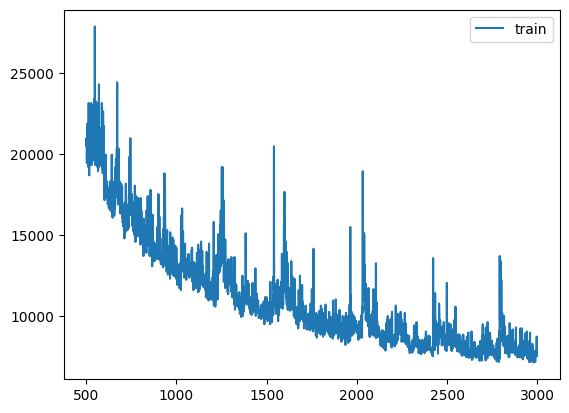

In [19]:
plt.plot(list(train_history.keys())[500:], list(train_history.values())[500:], label='train')
# plt.plot(val_history.keys(), val_history.values(), label='validation')
plt.legend()
plt.show()

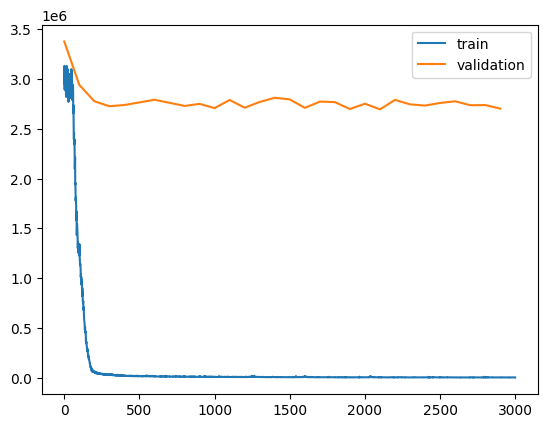

In [20]:
plt.plot(list(train_history.keys()), list(train_history.values()), label='train')
plt.plot(val_history.keys(), val_history.values(), label='validation')
plt.legend()
plt.show()

In [21]:
'''
# My results
At relu, model is stuck around 25k with 3x1000 steps with xavier
AT relu, moedl went to 9k and then exploded at 3x1000 steps with kaiming; then at 14k
At gelu, model is stuck atound 10k

Adam is better than AdamW for this task
'''

'\n# My results\nAt relu, model is stuck around 25k with 3x1000 steps with xavier\nAT relu, moedl went to 9k and then exploded at 3x1000 steps with kaiming; then at 14k\nAt gelu, model is stuck atound 10k\n\nAdam is better than AdamW for this task\n'

# Inference

In [22]:
fen_sample ='rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR b KQkq - 0 1'

In [23]:
def get_score(fen_sample):
    # encoding
    encoder_object = ChessEncoder()
    encoded_fen = torch.tensor(encoder_object.encode_fen(fen_i), dtype=torch.int32).to(device).view(70)
    # print(encoded_fen.shape)
    bs=1
    model = MLPEngine(embedding_dim=32).to(device)
    model.eval()
    y_pred = model(encoded_fen)
    return y_pred.item()
    # run the model

In [24]:
get_score(fen_sample)

1.49271559715271

# TODO
- [x] do inference
- [ ] look for other/ better dataset
- [ ] add regularisation
- [x] add proper initialisation
- [ ] Then start to think about architectural changes
- [ ] do some hyperparameter tuning, maybe grid search or something
  - [ ] **learning rate scheduler
  - [ ] embedding dimension changes
  - [ ] model neurons ++
  - [ ] **batch/ layer normalisation
  - [ ] different precision
  - [ ] custom loss function of the specific problem
  - [ ] Check for potential gradient vanishing/exploding

current precision is giving loss as int, fix it